# Importing Packages and Dataset

In [ ]:
!pip install pyagrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.1 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [ ]:
def load_data_cifar10(batch_size, resize=None):
    """Download the CIFAR-10 dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    cifar10_train = datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    cifar10_test = datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(cifar10_train, batch_size, shuffle=True,
                       num_workers=2, pin_memory=True),
            torch.utils.data.DataLoader(cifar10_test, batch_size, shuffle=False,
                       num_workers=2, pin_memory=True))

In [ ]:
batch_size = 64  # Defines the batch size
train_loader, test_loader = load_data_cifar10(batch_size)  # Loads the CIFAR-10 dataset.

100%|██████████| 170498071/170498071 [00:04<00:00, 42456944.42it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
X, y = next(iter(train_loader))  # Requests the first training batch
print(X.size())  # 64 images per batch. Each image is represented by a 3 x 32 x 32 tensor (number of channels x height x width). The images are RGB, so there are three channels.
print(y.size())  # 64 labels. Each label is a number between 0 and 9, representing the class of the image.

torch.Size([64, 3, 32, 32])
torch.Size([64])



Image 0 (bird):



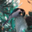


Image 1 (cat):



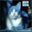


Image 2 (ship):



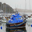

In [ ]:
#to view images
from google.colab.patches import cv2_imshow

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Pre-defined class labels for CIFAR-10

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.

# Creating Architecture

In [ ]:
class Block_1(torch.nn.Module):
    def __init__(self, input_channels, output_channels, dropout_rate=0.5):
        super(Block_1, self).__init__()

        self.Conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.Bn1 = torch.nn.BatchNorm2d(output_channels)
        self.Relu1 = torch.nn.ReLU()

        self.Conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.Bn2 = torch.nn.BatchNorm2d(output_channels)
        self.Relu2 = torch.nn.ReLU()

        self.Conv3 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.Bn3 = torch.nn.BatchNorm2d(output_channels)
        self.Dropout1 = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        out1 = self.Conv1(x)
        out1 = self.Bn1(out1)
        out1 = self.Relu1(out1)

        out2 = self.Conv2(out1)
        out2 = self.Bn2(out2)
        out2 = self.Relu2(out2)

        out3 = self.Conv3(out2)
        out3 = self.Bn3(out3)
        out3 = self.Dropout1(out3)

        # Adjust dimensions of out1 and out2 to match out3
        out1 = F.interpolate(out1, size=out3.shape[2:], mode='nearest')
        out2 = F.interpolate(out2, size=out3.shape[2:], mode='nearest')


        out = out1 + out2 + out3

        return out


In [ ]:
class Block_2(torch.nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, dropout_rate=0.1):
        super(Block_2, self).__init__()

        self.Conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=5, padding=2, stride=stride)
        self.Bn1n1 = torch.nn.BatchNorm2d(output_channels)
        self.Relu1 = torch.nn.ReLU()

        self.Conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=5, padding=2, stride=stride)
        self.Bn2n2 = torch.nn.BatchNorm2d(output_channels)
        self.Dropout1 = torch.nn.Dropout(dropout_rate)

        self.Conv3 = None
        if (input_channels != output_channels) or (stride != 1):
            self.Conv3 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride)

        self.Relu2 = torch.nn.ReLU()


    def forward(self, x):
        out1 = self.Conv1(x)
        out1 = self.Bn1n1(out1)
        out1 = self.Relu1(out1)

        out2 = self.Conv2(out1)
        out2 = self.Bn2n2(out2)
        out2 = self.Dropout1(out2)

        out3 = x if self.Conv3 is None else self.Conv3(x)

        out = self.Relu2(out1 + out2 + out3)

        return out


In [ ]:
class Block_3(torch.nn.Module):
   def __init__(self, input_channels, output_channels, dropout_rate=0.25):
        super(Block_3, self).__init__()

        self.Conv1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.Bn1 = torch.nn.BatchNorm2d(output_channels)
        self.Relu1 = torch.nn.ReLU()

        self.Conv2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.Bn2 = torch.nn.BatchNorm2d(output_channels)
        self.Relu2 = torch.nn.ReLU()

        self.Conv3 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, stride=1)
        self.Bn3 = torch.nn.BatchNorm2d(output_channels)
        self.Dropout1 = torch.nn.Dropout(dropout_rate)

   def forward(self, x):
        out1 = self.Conv1(x)
        out1 = self.Bn1(out1)
        out1 = self.Relu1(out1)

        out2 = self.Conv2(out1)
        out2 = self.Bn2(out2)
        out2 = self.Relu2(out2)

        out3 = self.Conv3(out2)
        out3 = self.Bn3(out3)
        out3 = self.Dropout1(out3)

        # Adjust dimensions of out1 and out2 to match out3
        out1 = F.interpolate(out1, size=out3.shape[2:], mode='nearest')
        out2 = F.interpolate(out2, size=out3.shape[2:], mode='nearest')

        out = out1 + out2 + out3

        return out

Checking each block with dummy data

In [ ]:
# from torchsummary import summary

# # Define your model
# model = Block_1(3, 64).to(device)

# # Pass a dummy input tensor through your model
# dummy_input = torch.randn(256, 3, 32, 32).to(device)  # dummy input tensor with appropriate dimensions
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     output = model(dummy_input)

# # Print the model summary
# summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
           Dropout-9           [-1, 64, 32, 32]               0
Total params: 76,032
Trainable params: 76,032
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 4.50
Params size (MB): 0.29
Estimated Total Size (MB): 4.80
---------------------------------------------

In [ ]:
# from torchsummary import summary

# # Define your model
# model = Block_2(64, 128).to(device)

# # Pass a dummy input tensor through your model
# dummy_input = torch.randn(256, 64, 32, 32).to(device)  # dummy input tensor with appropriate dimensions
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     output = model(dummy_input)

# # Print the model summary
# summary(model, input_size=(64, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]         204,928
       BatchNorm2d-2          [-1, 128, 32, 32]             256
              ReLU-3          [-1, 128, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]         409,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
           Dropout-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]           8,320
              ReLU-8          [-1, 128, 32, 32]               0
Total params: 623,488
Trainable params: 623,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 8.00
Params size (MB): 2.38
Estimated Total Size (MB): 10.63
----------------------------------------------------------------


In [ ]:
# # Define your model
# model = Block_3(128, 256).to(device)

# # Pass a dummy input tensor through your model
# dummy_input = torch.randn(256, 128, 32, 32).to(device)  # dummy input tensor with appropriate dimensions
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     output = model(dummy_input)

# # Print the model summary
# summary(model, input_size=(128, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]         295,168
       BatchNorm2d-2          [-1, 256, 32, 32]             512
              ReLU-3          [-1, 256, 32, 32]               0
            Conv2d-4          [-1, 256, 32, 32]         590,080
       BatchNorm2d-5          [-1, 256, 32, 32]             512
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         590,080
       BatchNorm2d-8          [-1, 256, 32, 32]             512
           Dropout-9          [-1, 256, 32, 32]               0
Total params: 1,476,864
Trainable params: 1,476,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 18.00
Params size (MB): 5.63
Estimated Total Size (MB): 24.13
-------------------------------------

In [ ]:
# # Create dummy input tensor
# dummy_input = torch.randn(1, 3, 32, 32).to(device)  # input size of (batch_size, channels, height, width)

# # Instantiate the blocks
# block1 = Block_1(input_channels=3, output_channels=64).to(device)
# block2 = Block_2(input_channels=64, output_channels=128).to(device)
# block3 = Block_3(input_channels=128, output_channels=256).to(device)

# # Pass the input through each block
# out1 = block1(dummy_input)
# out2 = block2(out1)
# out3 = block3(out2)

# # Print the shapes of the output tensors
# print("Output shape after Block 1:", out1.shape)
# print("Output shape after Block 2:", out2.shape)
# print("Output shape after Block 3:", out3.shape)

# # Print model summary
# from torchsummary import summary
# summary(block1, input_size=(3, 32, 32))
# summary(block2, input_size=(64, 16, 16))  # Input size after Block 1
# summary(block3, input_size=(128, 8, 8))   # Input size after Block 2


Output shape after Block 1: torch.Size([1, 64, 32, 32])
Output shape after Block 2: torch.Size([1, 128, 32, 32])
Output shape after Block 3: torch.Size([1, 256, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
           Dropout-9           [-1, 64, 32, 32]               0
Total params: 76,032
Trainable params: 76,032
Non-trainable params: 0
-------------------------------------------------------

In [ ]:
class OutputBlock(torch.nn.Module):
    def __init__(self, input_channels, num_outputs):
        super(OutputBlock, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()  # Flatten layer to flatten output of previous layer
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(input_channels, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(512, num_outputs)
        )

    def forward(self, x):
        avg_features = self.avg_pool(x)
        avg_features = self.flatten(avg_features)
        logits = self.fc_layers(avg_features)
        return logits


Architecture

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, num_outputs):
      super(Model, self).__init__()

      self.num_outputs = num_outputs
      self.block1 = Block_1(3, 64)
      self.block2 = Block_2(64, 128)
      self.block3 = Block_3(128, 256)
      self.output_block = OutputBlock(256, num_outputs)

    def forward(self, x):
      out = self.block1(x)
      out = self.block2(out)
      out = self.block3(out)
      logits = self.output_block(out)

      return logits

In [ ]:
model = Model(num_outputs=10).to(device)  # Assuming num_outputs=10 for CIFAR-10 classification

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10

model = Model(10).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

Model(
  (block1): Block_1(
    (Conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu1): ReLU()
    (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu2): ReLU()
    (Conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Dropout1): Dropout(p=0.5, inplace=False)
  )
  (block2): Block_2(
    (Conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Bn1n1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu1): ReLU()
    (Conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Bn2n2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

# Loss Function

In [ ]:
loss = torch.nn.CrossEntropyLoss()

In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

# Evaluation

In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [ ]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

# Training

In [ ]:
#reran again after finishing training !
model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_loader, correct)}. Testing accuracy: {evaluate_metric(model, test_loader, correct)}.')

Training accuracy: 0.9488799571990967. Testing accuracy: 0.8585999608039856.



Epoch 1/20.
Training accuracy: 0.5240600109100342. Testing accuracy: 0.5218999981880188. Duration: 125.441s.

Epoch 2/20.
Training accuracy: 0.5471000075340271. Testing accuracy: 0.5403000116348267. Duration: 125.618s.

Epoch 3/20.
Training accuracy: 0.5637800097465515. Testing accuracy: 0.5575000047683716. Duration: 125.731s.

Epoch 4/20.
Training accuracy: 0.618179976940155. Testing accuracy: 0.6015999913215637. Duration: 126.216s.

Epoch 5/20.
Training accuracy: 0.6808599829673767. Testing accuracy: 0.6553999781608582. Duration: 126.053s.

Epoch 6/20.
Training accuracy: 0.7691799998283386. Testing accuracy: 0.7423999905586243. Duration: 125.567s.

Epoch 7/20.
Training accuracy: 0.7919600009918213. Testing accuracy: 0.7622999548912048. Duration: 125.578s.

Epoch 8/20.
Training accuracy: 0.8282999992370605. Testing accuracy: 0.7931999564170837. Duration: 125.505s.

Epoch 9/20.
Training accuracy: 0.7608399987220764. Testing accuracy: 0.7252999544143677. Duration: 125.713s.

Epoch 10/2

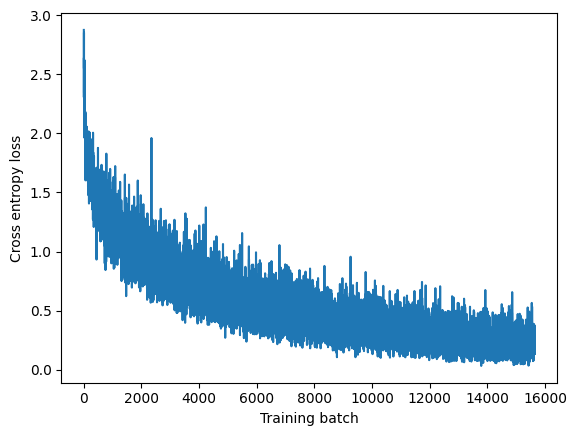

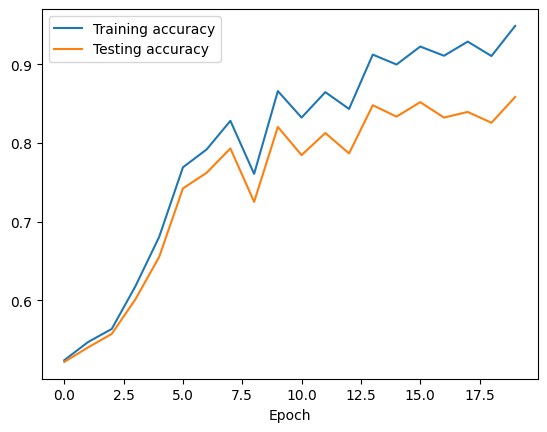

In [ ]:
import time
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 20
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_loader:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_loader, correct))
        test_accs.append(evaluate_metric(model, test_loader, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()